# Chatbot with message summarization

## Review
We've covered how to customize graph state schema and reducer.

We've also shown a number of ways to trim or filter messages in graph state.

##  Goals
Now, let's take it one step further!

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency.

In [1]:
%%capture --no-stdout --no-stderr
%pip install --quiet -U langchain_core langchain-openai langgraph

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.19 requires pydantic-settings<3.0.0,>=2.4.0, which is not installed.


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Enter {var}: ")

# _set_env("OPENAI_API_KEY")
_set_env("GOOGLE_API_KEY")

We'll use LangSmith for tracing.

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [5]:
# from langchain_openai import ChatOpenAI
# model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0)


from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

We'll use MessagesState, as before.

In addition to the built-in messages key, we'll now include a custom key (summary).

In [6]:
from langgraph.graph import MessagesState

class State(MessagesState):
    """The state of the chatbot."""
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [7]:
from langchain_core.messages import HumanMessage, RemoveMessage, SystemMessage

# Define the logic to call the LLM
def call_model(state: State):
    """Call the LLM with the current state of the chatbot."""
    # Get summary if it exists
    summary = state.get("summary", "")

    # if summary exists, add it to the messages
    if summary:
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    # Call the LLM
    response = model.invoke(messages)
    # Return the state
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [8]:
def summarize_conversation(state: State):
    """Summarize the conversation so far."""
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:
        # A summary already exists
        summary_message = (
            f"Summary of conversation so far: {summary}"
            f"\n\nNew messages: {state['messages'][-1].content}"
        )
    else:
        # No summary exists yet
        summary_message = f"Summarize the following conversation: {state['messages']}"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    # Return the state
    return {"messages": delete_messages, "summary": response.content}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [9]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Determine whether to end or summarize the conversation."""
    """Return the next node to execute."""
    
    messages = state['messages']

    # If there are more than six messages, then we summarize the conversation
    if(len(messages) > 6):
        return "summarize_conversation"
    
    # Otherwise, we end the conversation
    return END


## Adding memory

Recall that state is transient to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions.

As introduced at the end of Module 1, we can use persistence to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

As we previously showed, one of the easiest to work with is MemorySaver, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

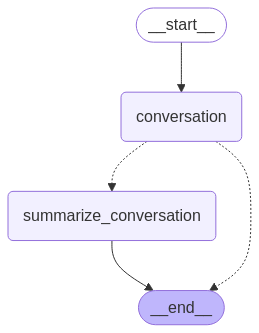

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile the graph with a checkpointer
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a thread of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use configurable to set a thread ID.

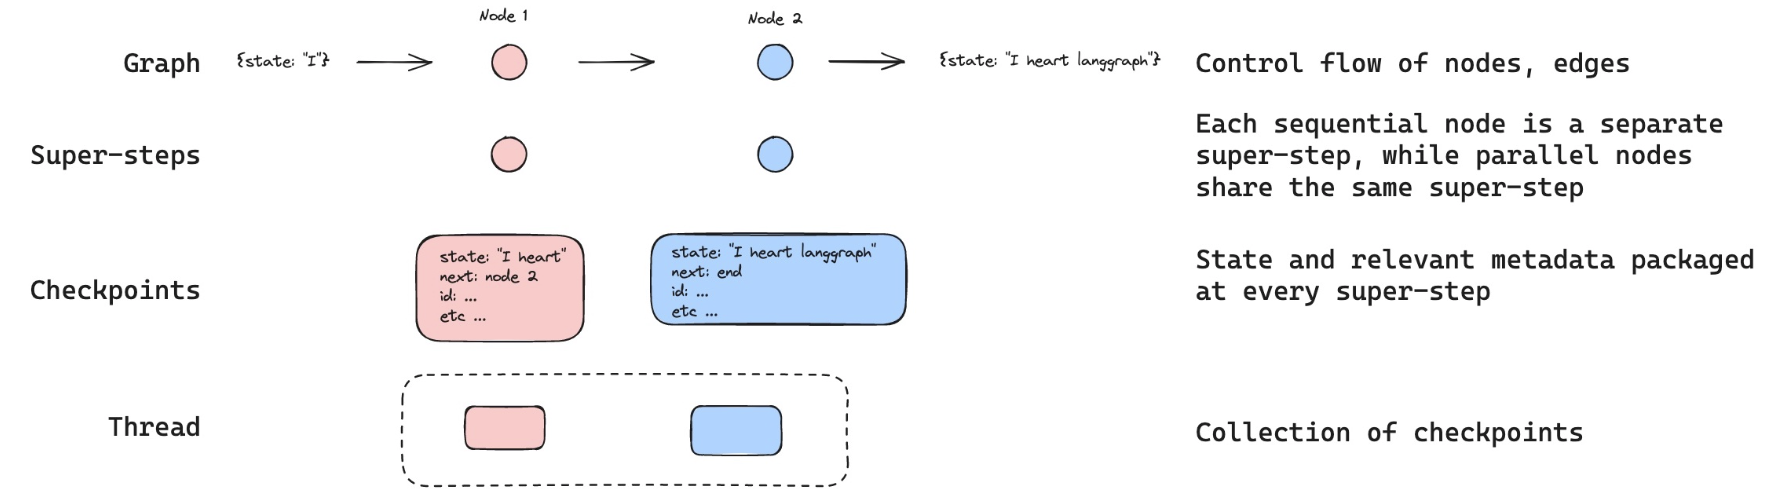

In [11]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance!  Nice to meet you.
================================== Ai Message ==================================

Your name is Lance.
================================== Ai Message ==================================

That's great!  Go Niners!  (Unless I'm talking to a Seahawks fan... 😉)


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in should_continue.

In [ ]:
   # If there are more than six messages, then we summarize the conversation
    # if len(messages) > 6:
    #     return "summarize_conversation"

We can pick up the conversation because we have the thread.

In [12]:
graph.get_state(config).values.get("summary", "")

''

The config with thread ID allows us to proceed from the previously logged state!

In [13]:
input_message = HumanMessage(content="I like Nick Bosa, isn't he the heighest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nick Bosa is incredibly highly paid, and was the highest-paid defensive player at the time of his contract extension.  However,  contracts are constantly being renegotiated in the NFL, so it's important to check recent news to be completely sure if he still holds that title.  There are often players close behind him in terms of yearly salary.


In [14]:
graph.get_state(config).values.get("summary", "")

"Lance introduced himself, confirmed his name, declared his fandom for the 49ers and Nick Bosa, and then inquired about Bosa's status as the highest-paid defensive player.  The AI confirmed Bosa's high salary but noted that the NFL's constantly changing contract landscape means his position at the top might not be guaranteed."